In [21]:
%reload_ext autoreload
%autoreload 2

import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from histogrammi_3D import *
# tai from ... import *

# Dataframe haku widgeteillä

In [22]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

In [3]:
#df = database_query("SELECT * FROM SensorData limit 100000")
#df.head(5)

# Kun haku on valmis niin dataframe tallenttuu df:ään

# Dataframe suodattaminen widgeteillä

In [23]:
#display(start_date, end_date, tunnit)
display(tunnit)

SelectionRangeSlider(description='Tunnit', index=(0, 14), options=(8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

In [24]:
# Kutstutaan sort_by_widgets ja boom dataframessa on ainoastaan 11-19 tunnit
df1 = sort_by_widgets(df)
df1.head()

,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.530,2762,-257,37,15,787
1,1,2020-06-24 15:20:08.620,2870,-344,38,14,738
2,1,2020-06-24 15:20:09.620,2916,-344,38,14,738
3,1,2020-06-24 15:20:09.620,2894,-254,38,15,788
4,1,2020-06-24 15:20:10.110,2888,-188,38,16,838


# Horrostilat dataframeen

In [25]:
df1 = horrostila(df1)
df1

,node_id,timestamp,x,y,x_grid,y_grid,grid_id,Horrostila
0,1,2020-06-24 15:20:08.530,2762,-257,37,15,787,False
1,1,2020-06-24 15:20:08.620,2870,-344,38,14,738,False
2,1,2020-06-24 15:20:09.620,2916,-344,38,14,738,False
3,1,2020-06-24 15:20:09.620,2894,-254,38,15,788,False
4,1,2020-06-24 15:20:10.110,2888,-188,38,16,838,False
...,...,...,...,...,...,...,...,...
8880,31,2020-06-24 15:33:01.220,2752,86,37,18,937,False
8881,31,2020-06-24 15:33:03.070,2920,15,38,17,888,False
8882,31,2020-06-24 15:33:03.580,2923,-120,39,16,839,False
8883,31,2020-06-24 15:33:04.740,2945,-198,39,16,839,False


## Piirretään horrostilat

Alkuperäiset nodet:  8885
Poistetut horrostilassa olevat nodet:  8431
Horrostilassa olevat nodet:  454


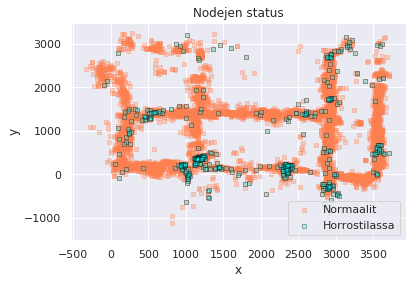

In [26]:
draw_horrostilat(df1, 'x', 'y')

# Piirretään nodejen käyttömäärä

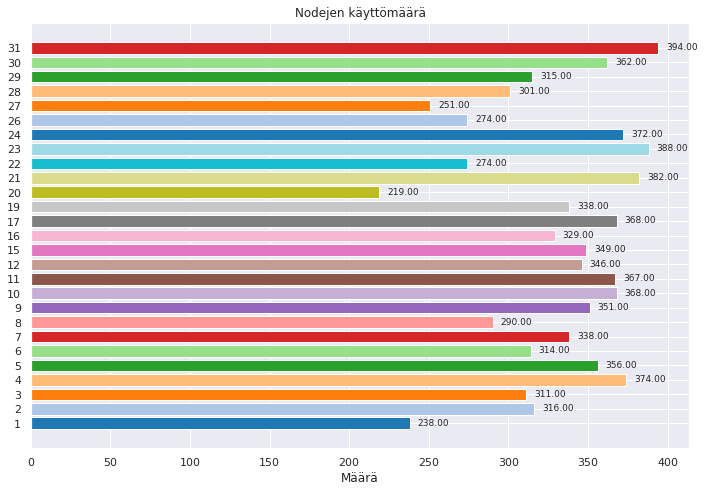

In [27]:
draw_node_amount(df1, 'node_id')

In [44]:
y = df1['y_grid'].values.tolist()
Y = ''.join("".join((map(str,y))))
Y

'151414151615161717171616162020202020212223242325262728313638454342424140404040383737373636363535343231313129303030303135363737384040414444434338373735353434333330303030303131302828272727262625252524231919191919181818181918162020212121212121212121212120212121212121222727282830312930303030303030292929262625252523212117171516171817181819202121222323232424252525252526262626273030313232323335353536363733333330312926251920211919191919171918192020201919191918181919191818161414143030303030303030303030282726262519171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717171717141515161516171819192020202121212222222223242527272728282827282828282728292727272727282827282834424244444341414445464645454645444446444544444445444447424240403939393939373736363534343232323130283029302929303029303130302221212020202020191919191920191919191615171516161616161616161616161516151616161615161616151616161616161616161515161516161615161515161516161

In [28]:
for i in df1['node_id'].unique():
    area_used = len(df[df["node_id"] == i]['grid_id'])/1600 * 100
    print(f"Node {i} used | {round(area_used,2)}% | of the store.")

#area_used = (len(df1['grid_id'].unique())/1600) * 100
#print(f"{area_used}%")

Node 1 used | 14.88% | of the store.
Node 2 used | 19.75% | of the store.
Node 3 used | 19.44% | of the store.
Node 4 used | 23.38% | of the store.
Node 5 used | 22.25% | of the store.
Node 6 used | 19.62% | of the store.
Node 7 used | 21.12% | of the store.
Node 8 used | 18.12% | of the store.
Node 9 used | 21.94% | of the store.
Node 10 used | 23.0% | of the store.
Node 11 used | 22.94% | of the store.
Node 12 used | 21.62% | of the store.
Node 15 used | 21.81% | of the store.
Node 16 used | 20.56% | of the store.
Node 17 used | 23.0% | of the store.
Node 19 used | 21.12% | of the store.
Node 20 used | 13.69% | of the store.
Node 21 used | 23.88% | of the store.
Node 22 used | 17.12% | of the store.
Node 23 used | 24.25% | of the store.
Node 24 used | 23.25% | of the store.
Node 26 used | 17.12% | of the store.
Node 27 used | 15.69% | of the store.
Node 28 used | 18.81% | of the store.
Node 29 used | 19.69% | of the store.
Node 30 used | 22.62% | of the store.
Node 31 used | 24.62% |

In [ ]:
def lcs(X , Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n+1) for i in range(m+1)] 
  
    """Following steps build L[m+1][n+1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m+1): 
        for j in range(n+1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j] , L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n] 
#end of function lcs 

# Driver program to test the above function
x = df1['x_grid'].values.tolist()
X = ''.join("".join((map(str,x))))
y = df1['y_grid'].values.tolist()
Y = ''.join("".join((map(str,y))))
print("Length of LCS is ", lcs(X, Y))

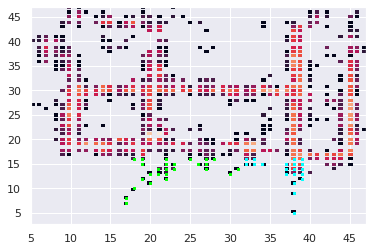

In [29]:
in_x, in_y = sisään(df1, 'x_grid', 'y_grid')
out_x, out_y = ulos(df1, 'x_grid', 'y_grid')

draw_exits(df1, in_x, in_y, out_x, out_y, 'x_grid', 'y_grid')

In [30]:
 # Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
grid_size= 40
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

In [31]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

#reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

#reitit = poista_lyhyet_reitit(reitit, grid_size)
#df_reitit = reitit_dataframeksi(reitit)
#reitit

In [32]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

NameError: name 'df_reitit' is not defined

# Piirretään 3D histogrammi

In [ ]:
## max(df1['x']), max(df1['y'])
df2 = df1.copy()
#df2.sort_values(["x", 'y'], ascending = False) 
#df2[df2[["x", 'y']][df2[["x", 'y']].max() > 0]]
#max_value = df2[df2['x'].max() >= 0]
indexNames = df2[ (df2['x'].max()) & (df2['y'].max()) ].index
df2.drop(indexNames , inplace=True)
df2

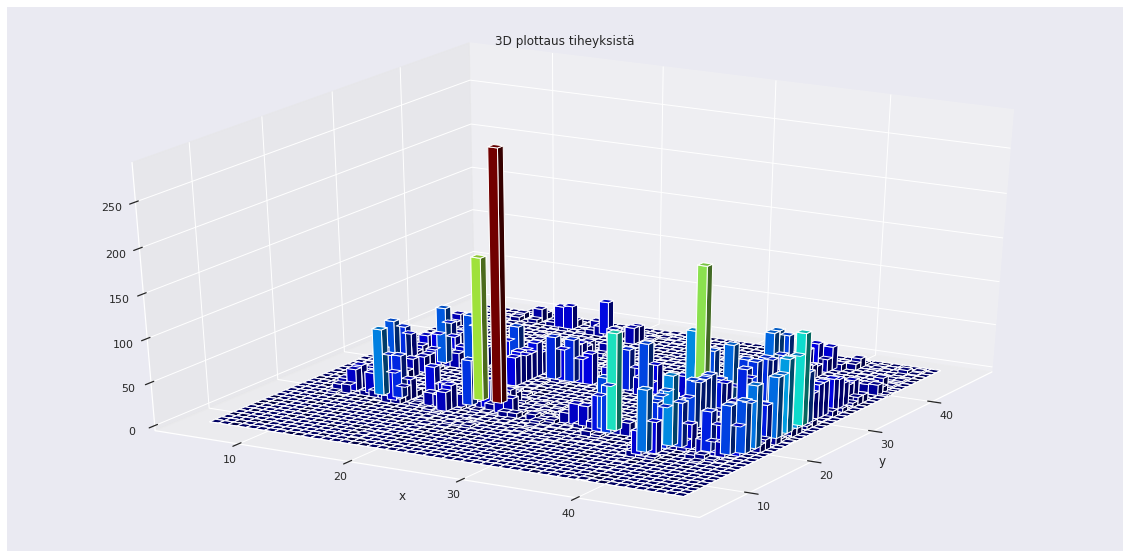

In [13]:
draw_3d(df1, 'grid_id', u_in_ID, u_out_ID)

In [9]:
aloitukset, lapimenoajat = get_lapimeno(reitit, grid_size)

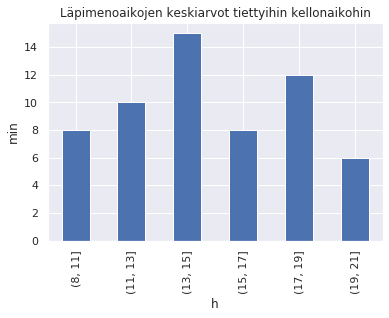

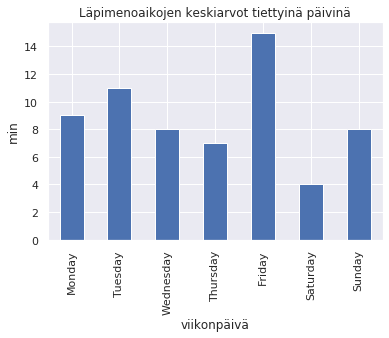

In [10]:
plot_lapimeno(aloitukset, lapimenoajat)

In [11]:
df_reitit['kesto']=df_reitit['kesto'].dt.total_seconds()

,ajokerta,node_id,timestamp,x,y,grid_id,kesto
0,1,1,2020-06-24 15:20:12.995,29,14,589,64857.237
1,1,1,2020-06-24 15:20:13.596,29,14,589,64857.237
2,1,1,2020-06-24 15:20:14.482,30,14,590,64857.237
3,1,1,2020-06-24 15:20:15.659,31,13,551,64857.237
4,1,1,2020-06-24 15:20:15.837,31,13,551,64857.237
...,...,...,...,...,...,...,...
374,97,1,2020-07-18 12:04:39.795,18,13,538,739.998
375,97,1,2020-07-18 12:04:40.795,18,13,538,739.998
376,97,1,2020-07-18 12:04:42.793,18,13,538,739.998
377,97,1,2020-07-18 12:04:51.793,18,13,538,739.998
